In [1]:
from collections import Counter
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# system

data_frame = pd.read_csv("./task2_dataset.csv")
data_frame["text"] = data_frame['keyword_1'] + ' ' + data_frame['keyword_2'] + ' ' + data_frame['keyword_3'];


In [3]:
# 1. ONE
# Vector generation

# tokenizing
data_frame['tokens'] = data_frame['text'].apply(lambda x: x.lower().split())

vocab = set([word for tokens in data_frame['tokens'] for word in tokens])
vocab = sorted(vocab)

word_index = {word: idx for idx, word in enumerate(vocab)}
print("Vocabulary", vocab)

# """
# bag of words

# bag of words matrix
bow_matrix = np.zeros((len(data_frame), len(vocab)), dtype=int)

for idx, tokens in enumerate(data_frame['tokens']):
    for token in tokens:
        word_idx = word_index.get(token)
        if word_idx is not None:
            bow_matrix[idx, word_idx] += 1 

bow_data_frame = pd.DataFrame(bow_matrix, columns=vocab)

# bow vector
def create_bow_vector(text, word_index, vocab):
    tokens = text.lower().split()
    vector = np.zeros(len(vocab), dtype=int)
    
    for token in tokens:
        if token in word_index:
            idx = word_index[token]
            vector[idx] += 1
    return vector

data_frame['keyword_1_vector'] = data_frame['keyword_1'].apply(lambda x: create_bow_vector(x, word_index, vocab))
data_frame['keyword_2_vector'] = data_frame['keyword_2'].apply(lambda x: create_bow_vector(x, word_index, vocab))
data_frame['keyword_3_vector'] = data_frame['keyword_3'].apply(lambda x: create_bow_vector(x, word_index, vocab))

# """

"""
# TF-IDF

def compute_tf(tokens, vocab):
    tf_vector = np.zeros(len(vocab), dtype=float)
    token_count = len(tokens)

    word_count = Counter(tokens)
    
    for word, count in word_count.items():
        if word in vocab:
            idx = vocab.index(word)
            tf_vector[idx] = count / token_count
    
    return tf_vector

def compute_idf(data_frame, vocab):
    n_documents = len(data_frame)
    idf_vector = np.zeros(len(vocab), dtype=float)

    for idx, word in enumerate(vocab):
        doc_count = sum(1 for tokens in data_frame['tokens'] if word in tokens)
        idf_vector[idx] = math.log(n_documents / max(1, doc_count)) + 1
    
    return idf_vector

def compute_tfidf(tokens, vocab, idf_vector):
    tf_vector = compute_tf(tokens, vocab)
    tfidf_vector = tf_vector * idf_vector
    return tfidf_vector

idf_vector = compute_idf(data_frame, vocab)

data_frame['keyword_1_vector'] = data_frame['keyword_1'].apply(lambda x: compute_tfidf(x.split(), vocab, idf_vector))
data_frame['keyword_2_vector'] = data_frame['keyword_2'].apply(lambda x: compute_tfidf(x.split(), vocab, idf_vector))
data_frame['keyword_3_vector'] = data_frame['keyword_3'].apply(lambda x: compute_tfidf(x.split(), vocab, idf_vector))

# """

keyword_1_vectors = np.vstack(data_frame['keyword_1_vector'].values)
keyword_2_vectors = np.vstack(data_frame['keyword_2_vector'].values)
keyword_3_vectors = np.vstack(data_frame['keyword_3_vector'].values)

Vocabulary ['acoustic', 'angry', 'banjo', 'brass', 'calm', 'danceable', 'distorted', 'emotional', 'energetic', 'fast', 'guitar', 'happy', 'heavy', 'mellow', 'melodic', 'nostalgic', 'piano', 'rhythmic', 'sad', 'slow', 'synth', 'twangy', 'upbeat', 'violin']


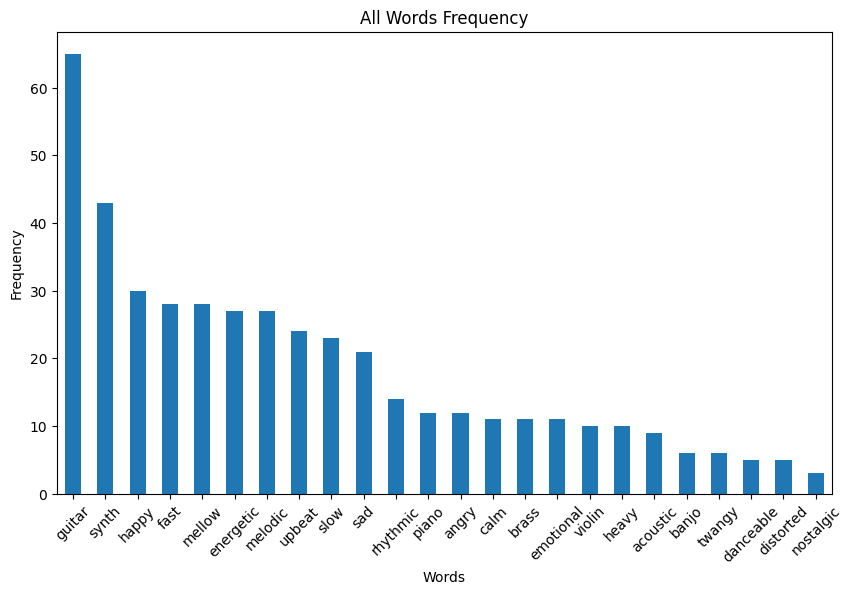

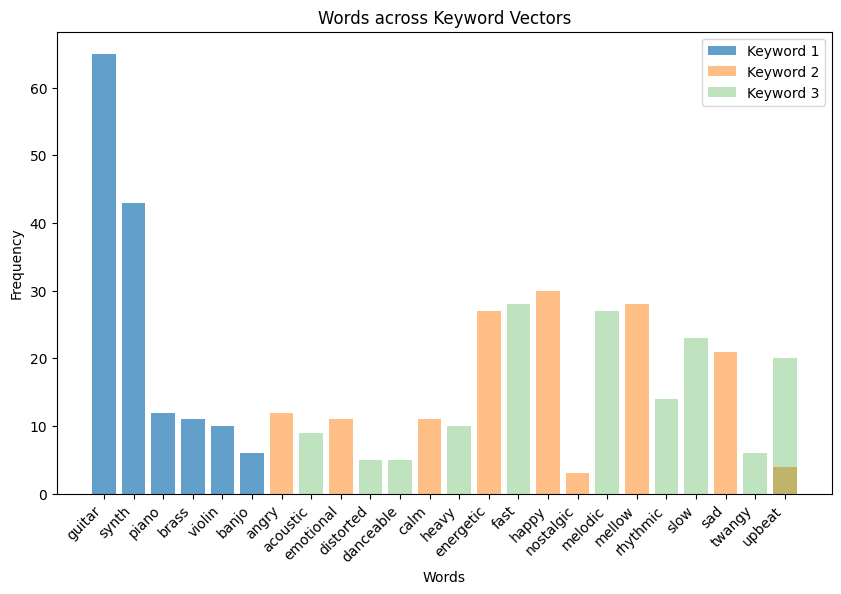

In [4]:
# Visualization

# token frequency visualization
word_counts = bow_data_frame.sum(axis=0).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
word_counts.plot(kind='bar')
plt.title("All Words Frequency")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.show()

# sum the vectors for each keyword to get overall word frequencies
keyword_1_sum = keyword_1_vectors.sum(axis=0)
keyword_2_sum = keyword_2_vectors.sum(axis=0)
keyword_3_sum = keyword_3_vectors.sum(axis=0)

# create a DataFrame for easier visualization
sum_vectors_df = pd.DataFrame({
    'word': vocab,
    'keyword_1_sum': keyword_1_sum,
    'keyword_2_sum': keyword_2_sum,
    'keyword_3_sum': keyword_3_sum
})

sum_vectors_df_sorted = sum_vectors_df.sort_values(by='keyword_1_sum', ascending=False)

plt.figure(figsize=(10, 6))

plt.bar(sum_vectors_df_sorted['word'], sum_vectors_df_sorted['keyword_1_sum'], label='Keyword 1', alpha=0.7)
plt.bar(sum_vectors_df_sorted['word'], sum_vectors_df_sorted['keyword_2_sum'], label='Keyword 2', alpha=0.5)
plt.bar(sum_vectors_df_sorted['word'], sum_vectors_df_sorted['keyword_3_sum'], label='Keyword 3', alpha=0.3)

plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Words across Keyword Vectors")
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.show()


In [5]:
# 2. TWO
# Dimension Reduction

class PCA_Custom:
    def __init__(self, n_components=2):
        self.n_components = n_components
        self.mean = None
        self.eigenvectors = None

    def fit(self, X):
        self.mean = np.mean(X, axis=0)
        X_centered = X - self.mean

        cov_matrix = np.cov(X_centered.T)
        cov_matrix += np.eye(cov_matrix.shape[0]) * 1e-6  # Regularization

        eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
        sorted_indices = np.argsort(eigenvalues)[::-1]

        self.eigenvectors = eigenvectors[:, sorted_indices[:self.n_components]]

    def transform(self, X):
        X_centered = X - self.mean
        return np.dot(X_centered, self.eigenvectors)

    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

pca_model = PCA_Custom(n_components=2)

X_keyword_1 = pca_model.fit_transform(keyword_1_vectors)
X_keyword_2 = pca_model.fit_transform(keyword_2_vectors)
X_keyword_3 = pca_model.fit_transform(keyword_3_vectors)


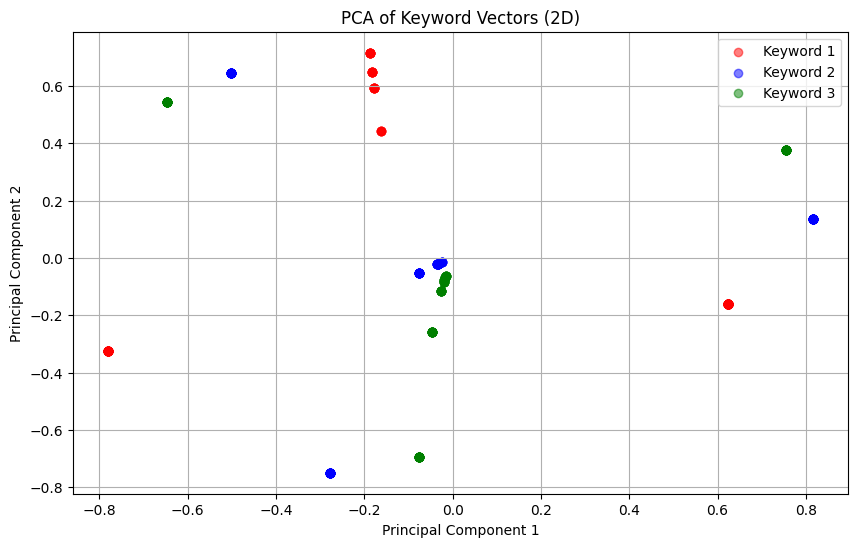

In [6]:
# Visualization

plt.figure(figsize=(10, 6))
plt.scatter(X_keyword_1[:, 0], X_keyword_1[:, 1], c='red', alpha=0.5, label="Keyword 1")
plt.scatter(X_keyword_2[:, 0], X_keyword_2[:, 1], c='blue', alpha=0.5, label="Keyword 2")
plt.scatter(X_keyword_3[:, 0], X_keyword_3[:, 1], c='green', alpha=0.5, label="Keyword 3")
plt.title("PCA of Keyword Vectors (2D)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid(True)
plt.show()


In [7]:
# 3. THREE
# Combining the embedding into one

X_combined = np.maximum(np.maximum(X_keyword_1, X_keyword_2), X_keyword_3)


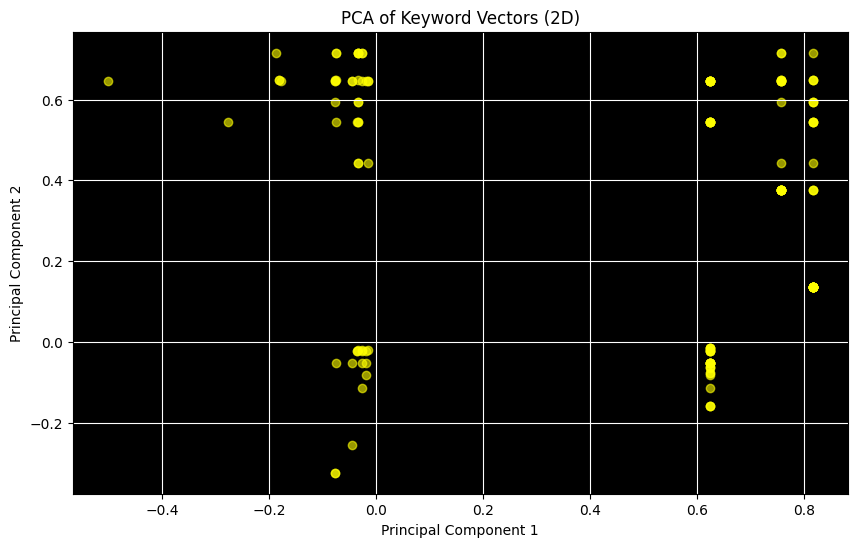

In [8]:
# Visualization

plt.figure(figsize=(10, 6))
plt.scatter(X_combined[:, 0], X_combined[:, 1], c='yellow', alpha=0.6)
plt.title("PCA of Keyword Vectors (2D)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True, color='white')
plt.gca().set_facecolor('black')
plt.show()


In [9]:
# 4. FOUR
# Clustering

# Using K Means

def initialize_centroids(X, k):
    np.random.seed(42)
    random_indices = np.random.choice(X.shape[0], k, replace=False)
    centroids = X[random_indices]
    return centroids


def assign_clusters(X, centroids):
    distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)
    cluster_assignments = np.argmin(distances, axis=1)
    return cluster_assignments


def update_centroids(X, cluster_assignments, k):
    centroids = np.array([X[cluster_assignments == i].mean(axis=0) for i in range(k)])
    return centroids


def kmeans(X, k, max_iters=1000):
    centroids = initialize_centroids(X, k)
    for _ in range(max_iters):
        cluster_assignments = assign_clusters(X, centroids)
        new_centroids = update_centroids(X, cluster_assignments, k)
        
        if np.all(centroids == new_centroids):
            break
        centroids = new_centroids
    
    return cluster_assignments, centroids


In [10]:
# Determining optimal K using elbow method

def compute_wcss(X, cluster_assignments, centroids):
    wcss = 0
    for i in range(len(centroids)):
        cluster_points = X[cluster_assignments == i, :]
        wcss += np.sum(np.linalg.norm(cluster_points - centroids[i], axis=1) ** 2)
    return wcss

def elbow_method(X, k_range):
    wcss = []
    for k in k_range:
        cluster_assignments, centroids = kmeans(X, k)
        wcss_value = compute_wcss(X, cluster_assignments, centroids)
        wcss.append(wcss_value)
    return wcss

def determine_elbow(wcss):
    diffs = np.diff(wcss)
    second_diffs = np.diff(diffs)
    return np.argmax(second_diffs) + 2


k_range = range(1, 11)
wcss = elbow_method(X_combined, k_range)

K_optimal = determine_elbow(wcss)

print("Optimal value for K in K Means = ", K_optimal)


C:\Users\neela\AppData\Local\Temp\ipykernel_14184\3642840266.py:20: RuntimeWarning: Mean of empty slice.
  centroids = np.array([X[cluster_assignments == i].mean(axis=0) for i in range(k)])
c:\projects\jupyter\venv\lib\site-packages\numpy\_core\_methods.py:139: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


Optimal value for K in K Means =  6


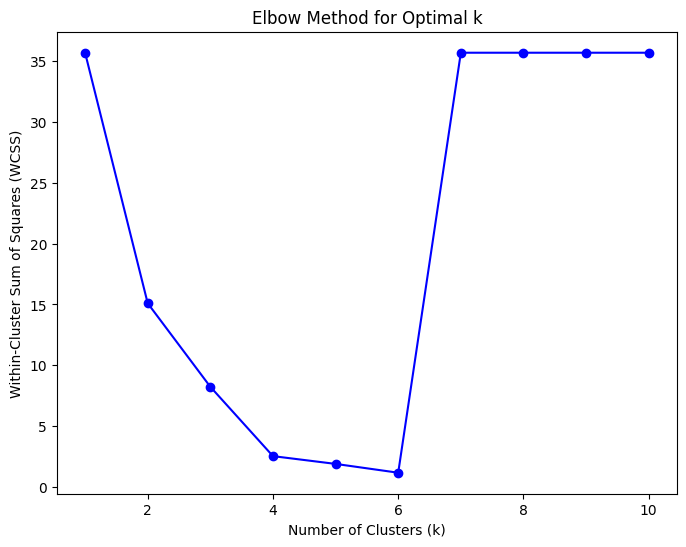

In [11]:
# Visualization

plt.figure(figsize=(8, 6))
plt.plot(k_range, wcss, marker='o', linestyle='-', color='b')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.show()


In [12]:
# Running the K cluster

cluster_assignments, centroids = kmeans(X_combined, K_optimal, 100000)


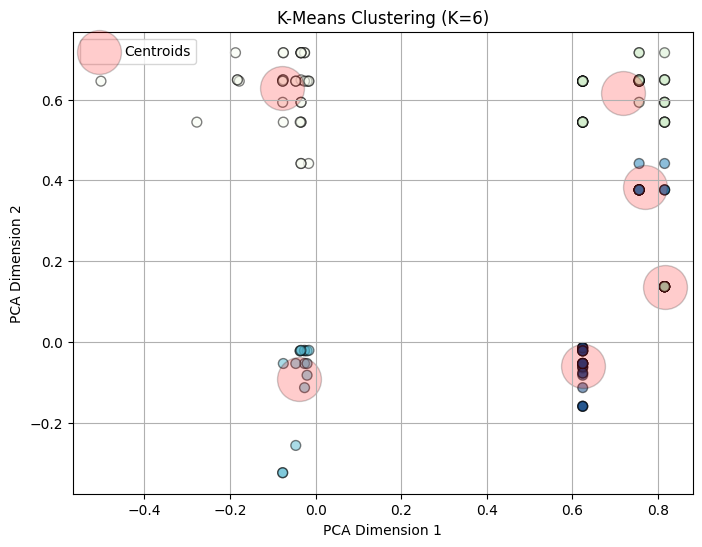

In [13]:
# Visualization

plt.figure(figsize=(8, 6))

plt.scatter(X_combined[:, 0], X_combined[:, 1], c=cluster_assignments, cmap='GnBu', s=50, alpha=0.5, edgecolors='k')
plt.scatter(centroids[:, 0], centroids[:, 1], marker='o', c='red', s=1000, edgecolors='k', label='Centroids', alpha=0.2)

plt.title(f'K-Means Clustering (K={K_optimal})')
plt.xlabel('PCA Dimension 1')
plt.ylabel('PCA Dimension 2')
plt.legend()
plt.grid(True)
plt.show()


In [14]:
# 5. FIVE
# Truth Analysis

def silhouette_score(X, cluster_assignments, centroids):
    n_samples = X.shape[0]
    silhouette_scores = []
    
    # function to compute the average distance of a point to all other points in the same cluster
    def avg_distance_in_cluster(point, cluster_points):
        if len(cluster_points) <= 1:
            return 0  # Avoid division by zero when only one point in the cluster
        return np.mean(np.linalg.norm(cluster_points - point, axis=1))
    
    # function to compute the average distance of a point to the nearest different cluster
    def avg_distance_to_nearest_cluster(point, X, cluster_assignments, current_cluster):
        min_avg_distance = float('inf')
        for cluster in np.unique(cluster_assignments):
            if cluster == current_cluster:
                continue
            
            other_cluster_points = X[np.where(cluster_assignments == cluster)]
            avg_distance = np.mean(np.linalg.norm(other_cluster_points - point, axis=1))
            min_avg_distance = min(min_avg_distance, avg_distance)
        
        return min_avg_distance
    
    # calculate silhouette score for each point
    for i in range(n_samples):
        point = X[i]
        cluster_idx = cluster_assignments[i]
        
        cluster_points = X[cluster_assignments == cluster_idx]
        
        a_i = avg_distance_in_cluster(point, cluster_points)
        
        b_i = avg_distance_to_nearest_cluster(point, X, cluster_assignments, cluster_idx)
        
        if max(a_i, b_i) == 0:
            s_i = 0
        else:
            s_i = (b_i - a_i) / max(a_i, b_i)
        
        silhouette_scores.append(s_i)
    
    return np.mean(silhouette_scores)


score = silhouette_score(X_combined, cluster_assignments, centroids)
print(f"Silhouette Score: {score:.4f}")


Silhouette Score: 0.7655


In [15]:

df_results = pd.DataFrame({'song_id': data_frame["song_id"], 'cluster': cluster_assignments, 'true_genre': data_frame["genre"]})

cluster_to_genre = df_results.groupby('cluster')['true_genre'].agg(lambda x: x.value_counts().idxmax())

df_results['predicted_genre'] = df_results['cluster'].map(cluster_to_genre)

accuracy = (df_results['predicted_genre'] == df_results['true_genre']).mean()
print(f"Clustering Accuracy: {accuracy:.2%}\n")


cluster_genre_distribution = df_results.groupby(['cluster', 'true_genre']).size().unstack(fill_value=0)
cluster_genre_percentage = cluster_genre_distribution.div(cluster_genre_distribution.sum(axis=1), axis=0) * 100
print(cluster_genre_percentage)



Clustering Accuracy: 40.14%

true_genre  classical    country    hip-hop        pop       rock
cluster                                                          
0           42.857143  11.428571  22.857143  22.857143   0.000000
1           31.578947  23.684211   5.263158  13.157895  26.315789
2            0.000000  20.000000  26.666667  26.666667  26.666667
3            0.000000   0.000000  75.000000  25.000000   0.000000
4            0.000000  25.000000  25.000000  25.000000  25.000000
5            0.000000  33.333333   0.000000  22.222222  44.444444


In [16]:
def predict_genre(keyword_1, keyword_2, keyword_3):
    input_vector_1 = create_bow_vector(keyword_1, word_index, vocab)
    input_vector_2 = create_bow_vector(keyword_2, word_index, vocab)
    input_vector_3 = create_bow_vector(keyword_3, word_index, vocab)
    
    input_pca_1 = pca_model.transform(input_vector_1.reshape(1, -1))
    input_pca_2 = pca_model.transform(input_vector_2.reshape(1, -1))
    input_pca_3 = pca_model.transform(input_vector_3.reshape(1, -1))
    
    input_combined = np.maximum(np.maximum(input_pca_1, input_pca_2), input_pca_3)
    
    distances = np.linalg.norm(centroids - input_combined, axis=1)
    assigned_cluster = np.argmin(distances)
    
    return cluster_to_genre.get(assigned_cluster, "Unknown")


keyword_1 = "brass"
keyword_2 = "happy"
keyword_3 = "fast"

predicted_genre = predict_genre(keyword_1, keyword_2, keyword_3)
print(f"Predicted Genre: {predicted_genre}")


Predicted Genre: country
